<a href="https://colab.research.google.com/github/Justabhi96/advanced_computer_vision/blob/master/07_Object_Localization_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make the pokemon of different sizes also flip the pokemon randomly

In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [0]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2020-02-09 18:35:05--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2020-02-09 18:35:05 (96.2 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image

In [0]:
IMAGE_SIZE = [200, 200, 3]

In [0]:
vgg = VGG16(input_shape = IMAGE_SIZE, weights = "imagenet", include_top = False)

x = Flatten()(vgg.output)
x = Dense(4, activation = "sigmoid")(x)
model = Model(vgg.input, x)

58892288/58889256 [==============================] - 1s 0us/step


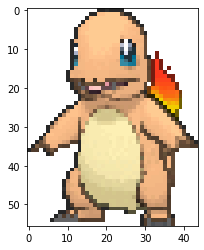

In [0]:
ch_image = imageio.imread("charmander-tight.png")
plt.imshow(ch_image)

In [0]:
ch_image = np.array(ch_image)
ch_h, ch_w, _ = ch_image.shape
ch_h, ch_w

(56, 44)

In [0]:
from skimage.transform import resize
import cv2

def image_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros([batch_size] + IMAGE_SIZE)
      Y = np.zeros([batch_size, 4])

      for i in range(batch_size):
        # to make charmander bigger or smaller
        scale = 0.5 + np.random.random() #[0.5, 1.5]
        new_h = int(ch_h * scale)
        new_w = int(ch_w * scale)

        if np.random.random() < 0.5:
          ch_temp_image = np.fliplr(ch_image)
        else:
          ch_temp_image = ch_image
        new_ch_img = resize(ch_temp_image, (new_h, new_w), 
                            preserve_range=True).astype(np.uint8) # to keep the range 0 - 255
        row0 = np.random.randint(0, IMAGE_SIZE[0] - new_h)
        col0 = np.random.randint(0, IMAGE_SIZE[0] - new_w)
        row1 = row0 + new_h
        col1 = col0 + new_w

        X[i, row0:row1, col0:col1, :] = new_ch_img[:,:,:3]
        Y[i, 0] = row0/IMAGE_SIZE[0]
        Y[i, 1] = col0/IMAGE_SIZE[0]
        Y[i, 2] = (col1-col0)/IMAGE_SIZE[0]
        Y[i, 3] = (row1-row0)/IMAGE_SIZE[0]

      yield X/255.0, Y

In [0]:
# Notice learning rate is 10th of previous netebook
model.compile(optimizer=Adam(lr = 0.0001), loss = "binary_crossentropy")
model.fit_generator(image_generator(), epochs = 5, steps_per_epoch=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/5
50/50 [==============================] - 50s 1s/step - loss: 0.5582
Epoch 2/5
50/50 [==============================] - 34s 690ms/step - loss: 0.5432
Epoch 3/5
50/50 [==============================] - 35s 704ms/step - loss: 0.5450
Epoch 4/5
50/50 [==============================] - 36s 712ms/step - loss: 0.5431
Epoch 5/5
50/50 [==============================] - 36s 711ms/step - loss: 0.5422


In [0]:
from matplotlib.patches import Rectangle
ref_size = IMAGE_SIZE[0]

def make_prediction():
  # to make charmander bigger or smaller
  scale = 0.5 + np.random.random() #[0.5, 1.5]
  new_h = int(ch_h * scale)
  new_w = int(ch_w * scale)
  if np.random.random() < 0.5:
    ch_temp_image = np.fliplr(ch_image)
  else:
    ch_temp_image = ch_image
  new_ch_img = resize(ch_temp_image, (new_h, new_w), 
                            preserve_range=True).astype(np.uint8)
  row0 = np.random.randint(0, ref_size - new_h)
  col0 = np.random.randint(0, ref_size - new_w)
  row1 = row0 + new_h
  col1 = col0 + new_w
  x = np.zeros(IMAGE_SIZE)
  x[row0:row1, col0:col1, :] = new_ch_img[:,:,:3]

  X = np.expand_dims(x, 0)
  p = model.predict(X/255.0)[0]
  print((p[0]*ref_size, p[1]*ref_size, p[2]*ref_size, p[3]*ref_size))
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle((p[1]*ref_size, p[0]*ref_size), 
                   p[2]*ref_size, p[3]*ref_size, 
                   linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

(102.08652019500732, 129.98167276382446, 28.74906361103058, 36.3438755273819)


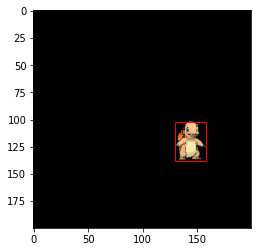

In [0]:
make_prediction()